In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import MonthEnd
import statsmodels.formula.api as smf
import seaborn as sns
import yfinance as yf
from scipy.stats.mstats import winsorize

## 1. Preprocess

### 1.1 COMPUSTAT Data

#### 1.1.1 Load Data

In [13]:
cstat = pd.read_feather('cstat.feather')
cstat

,index,PERMNO,DATE,CURCDQ,ACTQ,CEQQ,EPSPXQ,OIADPQ,IVCHY,REVTY,COSTAT,MKVALTQ,NAICS
0,0,10001,2000-06-30,USD,16.287,13.961,-0.06,-0.145,NaN,72.196,I,NaN,22
1,1,10001,2000-09-30,USD,20.527,13.635,-0.24,0.184,0.0,16.419,I,NaN,22
2,2,10001,2000-12-31,USD,30.677,14.330,0.54,1.976,0.0,44.947,I,NaN,22
3,3,10001,2001-03-31,USD,32.211,16.759,1.04,4.634,0.0,84.935,I,NaN,22
4,4,10001,2001-06-30,USD,26.622,15.613,-0.22,-0.571,0.0,120.161,I,NaN,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536577,538602,93436,2021-09-30,USD,25002.000,27053.000,1.62,2055.000,0.0,36104.000,A,778581.92,33
536578,538603,93436,2021-12-31,USD,27100.000,30189.000,2.29,2613.000,0.0,53823.000,A,1091653.74,33
536579,538604,93436,2022-03-31,USD,29050.000,34085.000,3.20,3603.000,0.0,18756.000,A,1116393.60,33
536580,538605,93436,2022-06-30,USD,31222.000,36376.000,2.18,2606.000,0.0,35690.000,A,701030.22,33


COMPUSTAT Reference Table:
1. CURCDQ: Currency of the financial report.
2. ACTQ: Total current assets.
3. CEQQ: Total common equity.
4. EPSPXQ: Earnings per share.
5. OIADPQ: Operating income after depreciation.
6. IVCHY: Increase in investments.
7. REVTY: Total revenue.
8. COSTAT: Active/Inactive company status.
9. MKVALTQ: Total market value.
10. NAICS: North American Industry Classification Code.

#### 1.1.2 Clean Dataset

In [14]:
cstat['COSTAT'].value_counts()

A    324201
I    212381
Name: COSTAT, dtype: int64

In [15]:
cstat = cstat[cstat['COSTAT'] == 'A']

As we can see here, there are more than 200,000 entries of inactive company reports. Naturally, we expect inactive companies to have different behaviors comparing to active companies. Thus, we will only look at companies whoose status is active.

In [16]:
cstat['CURCDQ'].value_counts()

USD    318969
CAD      5232
Name: CURCDQ, dtype: int64

In [17]:
cstat = cstat[cstat['CURCDQ'] == 'USD']

In [18]:
cstat.shape

(318969, 13)

Similarly, to make our dataset more homogeneous, we will also remove the companies reporting in CAD instead of US dollars.

#### 1.1.3 Handling Missing Values
Since we would like to be rigorous in our treatment of values. We will choose to drop data if imputation is not resonable / feasible

In [19]:
print('---Percentage of nan values---')
(cstat.isna().sum() / len(cstat)).sort_values(ascending=False)

---Percentage of nan values---


MKVALTQ    0.334384
ACTQ       0.297499
IVCHY      0.187485
REVTY      0.186626
OIADPQ     0.115726
CEQQ       0.109186
EPSPXQ     0.104327
index      0.000000
PERMNO     0.000000
DATE       0.000000
CURCDQ     0.000000
COSTAT     0.000000
NAICS      0.000000
dtype: float64

As we see, the majority of missing values are from the columns MKVALTQ and ACTQ. For market value, we can easily fill in the nan value from the CRSP shares outstanding multiplied by price of the shares. For ACTQ and all other ones, however, we have to drop those.

In [20]:
cstat = cstat[~cstat[cstat.columns.drop('MKVALTQ')].isna().any(axis=1)]
print(f'---Cstat length after removing missing entries: {len(cstat)}---')

---Cstat length after removing missing entries: 206221---


### 1.2 CRSP Stock Data

#### 1.2.1 Load Data

In [21]:
stocks = pd.read_feather('crsp.feather')
stocks

,PERMNO,Ticker,DATE,DlyPrc,DlyClose,ShrOut
0,10001,EGAS,2000-01-03,8.5625,8.5625,2450.0
1,10001,EGAS,2000-01-04,8.4375,8.4375,2450.0
2,10001,EGAS,2000-01-05,8.5625,8.5625,2450.0
3,10001,EGAS,2000-01-06,8.5000,8.5000,2450.0
4,10001,EGAS,2000-01-07,8.4375,8.4375,2450.0
...,...,...,...,...,...,...
40543147,93436,TSLA,2022-02-23,764.0400,764.0400,1033508.0
40543148,93436,TSLA,2022-02-24,800.7700,800.7700,1033508.0
40543149,93436,TSLA,2022-02-25,809.8700,809.8700,1033508.0
40543150,93436,TSLA,2022-02-28,870.4300,870.4300,1033508.0


In [22]:
(stocks['DlyPrc'] > 0).value_counts()

True     39940121
False      603031
Name: DlyPrc, dtype: int64

In [23]:
stocks['DlyPrc'] = np.abs(stocks['DlyPrc'])

Now, observe that some of our prices are negative. According to CRSP's documentation, negative prices indicates they are not the realized prices at closing, but rather the middle of the bid-ask spread at close. Hence, we can safely convert all these values to positive numbers.

#### 1.2.2 Stock Missing Values

In [24]:
stocks.isna().sum(axis=0)

PERMNO            0
Ticker          240
DATE              0
DlyPrc       594105
DlyClose    1972179
ShrOut        12697
dtype: int64

It seems like there are a lot more missing values for daily closing prices, so we will use DlyPrc only and drop those closing prices. Also, all other missing entries are subsequently dropped.

In [25]:
stocks = stocks.dropna().drop(['Ticker','DlyClose'],axis=1)

### 1.3 Merge CRSP and COMPUSTAT

In [26]:
cstat = pd.merge(stocks,cstat,how='inner',on=['PERMNO','DATE'])

In [27]:
mv = cstat['ShrOut'] * cstat['DlyPrc']
cstat['MKVALTQ'] = round(cstat['MKVALTQ'].fillna(mv/1000))
cstat = cstat.dropna()
cstat

,PERMNO,DATE,DlyPrc,ShrOut,index,CURCDQ,ACTQ,CEQQ,EPSPXQ,OIADPQ,IVCHY,REVTY,COSTAT,MKVALTQ,NAICS
0,10026,2000-06-30,17.875,8542.0,215,USD,61.009,129.923,0.57,8.620,0.0,222.207,A,153.0,31
1,10026,2001-12-31,24.450,8654.0,221,USD,60.182,147.584,0.10,1.480,0.0,74.797,A,212.0,31
2,10026,2002-09-30,36.850,8903.0,224,USD,75.367,168.709,0.84,11.539,0.0,353.187,A,328.0,31
3,10026,2002-12-31,35.710,8905.0,225,USD,74.749,169.881,0.14,1.810,0.0,77.244,A,318.0,31
4,10026,2003-03-31,30.320,8742.0,226,USD,80.996,167.484,0.34,4.623,0.0,158.652,A,265.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134877,93436,2020-12-31,705.670,959854.0,538599,USD,26717.000,22225.000,0.28,575.000,0.0,31536.000,A,677443.0,33
134878,93436,2021-03-31,667.930,963000.0,538600,USD,24705.000,23017.000,0.46,493.000,0.0,10389.000,A,643217.0,33
134879,93436,2021-06-30,679.700,984003.0,538601,USD,24693.000,24804.000,1.18,1335.000,0.0,22347.000,A,668825.0,33
134880,93436,2021-09-30,775.480,1004000.0,538602,USD,25002.000,27053.000,1.62,2055.000,0.0,36104.000,A,778582.0,33


Filled in the previoulsy mentioned missing features of market cap data with the data avaliable in CRSP.

#### 1.3.1 Computing Required Factors

We will add the following factors (Note that all generated factors are lower case while the original columns are in upper case).
1. actqg: Asset growth rate. atg = current period ACTQ / previous period actq
2. pb: Price to Book ratio. pb = market value / total common equity
3. roe: Return on Equity. roe = Income (We use opearting income) / total common equity
4. beta: the market beta of the period from our previous observation to the next observation.
5. ret_1: The lead return on the stock from the current time stamp to the next time stamp.

* Now, we have every component of the Fama-French 5 factor model in our dataset. SMB is proxied by market cap, HML is proxied by PB ratio, RMW is proxied by roe, CMA is proxied by increase in investments (IVCHY)

In [28]:
cstat = cstat.set_index(['PERMNO','DATE'])

In [29]:
grouped = cstat.groupby(['PERMNO'])
cstat['actqg'] = grouped['ACTQ'].pct_change().clip(-10,10)
# cstat['actqg'] = grouped['ACTQ'].pct_change().clip(-10,10)
cstat['pb'] = cstat['MKVALTQ']/cstat['CEQQ'].clip(-100,100)
cstat['roe'] = cstat['OIADPQ']/cstat['CEQQ'].clip(-100,100)
cstat['ret_1'] = grouped['DlyPrc'].pct_change().shift(-2)

cstat['NAICS'] = cstat['NAICS'].astype('category')
cstat['quarters'] = np.floor(cstat.reset_index().groupby(['PERMNO'])['DATE'].diff().dt.days / 90).values
# cstat = cstat.drop(['DlyPrc','ShrOut','index','CURCDQ','COSTAT'],axis=1).dropna()

cstat.dropna(inplace=True)
cstat

DlyPrc    ShrOut   index CURCDQ       ACTQ       CEQQ  \
PERMNO DATE                                                                 
10026  2001-12-31    24.45    8654.0     221    USD     60.182    147.584   
       2002-09-30    36.85    8903.0     224    USD     75.367    168.709   
       2002-12-31    35.71    8905.0     225    USD     74.749    169.881   
       2003-03-31    30.32    8742.0     226    USD     80.996    167.484   
       2003-06-30    31.40    8868.0     227    USD     90.863    173.262   
...                    ...       ...     ...    ...        ...        ...   
93436  2020-06-30  1079.81  186000.0  538597    USD  15336.000   9855.000   
       2020-09-30   429.01  948000.0  538598    USD  21744.000  16031.000   
       2020-12-31   705.67  959854.0  538599    USD  26717.000  22225.000   
       2021-03-31   667.93  963000.0  538600    USD  24705.000  23017.000   
       2021-06-30   679.70  984003.0  538601    USD  24693.000  24804.000   

                   EPSPXQ    OIADPQ  IVCHY      REVTY COSTAT   MKVALTQ NAICS  \
PERMNO DATE                                                                    
10026  2001-12-31    0.10     1.480    0.0     74.797      A     212.0    31   
       2002-09-30    0.84    11.539    0.0    353.187      A     328.0    31   
       2002-12-31    0.14     1.810    0.0     77.244      A     318.0    31   
       2003-03-31    0.34     4.623    0.0    158.652      A     265.0    31   
       2003-06-30    0.91    12.157    0.0    261.181      A     278.0    31   
...                   ...       ...    ...        ...    ...       ...   ...   
93436  2020-06-30    0.56   536.000    0.0  12021.000      A  200845.0    33   
       2020-09-30    0.32   766.000    0.0  20792.000      A  406701.0    33   
       2020-12-31    0.28   575.000    0.0  31536.000      A  677443.0    33   
       2021-03-31    0.46   493.000    0.0  10389.000      A  643217.0    33   
       2021-06-30    1.18  1335.000    0.0  22347.000      A  668825.0    33   

                      actqg       pb       roe     ret_1  quarters  
PERMNO DATE                                                         
10026  2001-12-31 -0.013555     2.12   0.01480 -0.030936       6.0  
       2002-09-30  0.252318     3.28   0.11539 -0.150938       3.0  
       2002-12-31 -0.008200     3.18   0.01810  0.035620       1.0  
       2003-03-31  0.083573     2.65   0.04623  0.139490       1.0  
       2003-06-30  0.121821     2.78   0.12157  0.055338       1.0  
...                     ...      ...       ...       ...       ...  
93436  2020-06-30  0.029746  2008.45   5.36000  0.644880       1.0  
       2020-09-30  0.417840  4067.01   7.66000 -0.053481       1.0  
       2020-12-31  0.228707  6774.43   5.75000  0.017622       1.0  
       2021-03-31 -0.075308  6432.17   4.93000  0.140915       1.0  
       2021-06-30 -0.000486  6688.25  13.35000  0.362743       1.0  

[124607 rows x 18 columns]

#### 1.3.2 Load Stock Beta

In [30]:
beta = pd.read_feather('beta.feather')[['PERMNO','DATE','B_MKT']]
cstat = pd.merge(cstat,beta,how='inner',on=['PERMNO','DATE'])
cstat

,PERMNO,DATE,DlyPrc,ShrOut,index,CURCDQ,ACTQ,CEQQ,EPSPXQ,OIADPQ,...,REVTY,COSTAT,MKVALTQ,NAICS,actqg,pb,roe,ret_1,quarters,B_MKT
0,10026,2001-12-31,24.45,8654.0,221,USD,60.182,147.584,0.10,1.480,...,74.797,A,212.0,31,-0.013555,2.12,0.01480,-0.030936,6.0,0.9372
1,10026,2002-09-30,36.85,8903.0,224,USD,75.367,168.709,0.84,11.539,...,353.187,A,328.0,31,0.252318,3.28,0.11539,-0.150938,3.0,0.7866
2,10026,2002-12-31,35.71,8905.0,225,USD,74.749,169.881,0.14,1.810,...,77.244,A,318.0,31,-0.008200,3.18,0.01810,0.035620,1.0,0.6919
3,10026,2003-03-31,30.32,8742.0,226,USD,80.996,167.484,0.34,4.623,...,158.652,A,265.0,31,0.083573,2.65,0.04623,0.139490,1.0,0.7413
4,10026,2003-06-30,31.40,8868.0,227,USD,90.863,173.262,0.91,12.157,...,261.181,A,278.0,31,0.121821,2.78,0.12157,0.055338,1.0,0.7071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101324,93436,2020-06-30,1079.81,186000.0,538597,USD,15336.000,9855.000,0.56,536.000,...,12021.000,A,200845.0,33,0.029746,2008.45,5.36000,0.644880,1.0,1.2631
101325,93436,2020-09-30,429.01,948000.0,538598,USD,21744.000,16031.000,0.32,766.000,...,20792.000,A,406701.0,33,0.417840,4067.01,7.66000,-0.053481,1.0,1.6488
101326,93436,2020-12-31,705.67,959854.0,538599,USD,26717.000,22225.000,0.28,575.000,...,31536.000,A,677443.0,33,0.228707,6774.43,5.75000,0.017622,1.0,1.7767
101327,93436,2021-03-31,667.93,963000.0,538600,USD,24705.000,23017.000,0.46,493.000,...,10389.000,A,643217.0,33,-0.075308,6432.17,4.93000,0.140915,1.0,1.7609


These beta values are ex-ante beta computed monthly using an estimation window of 90 previous days, with the minimum window set to 45 days. These betas are CAPM single factor betas.

## 2. Analysis

### 2.1 Visualization & Exporation of Data

#### 2.1.1 Visualizing Correlation
Since we would like to prove the growth of asset is a completely new factor independent of the previously explored factors, we will plot the correlationship between every factor and see if growth of asset is highly correlated to the other factors.

<AxesSubplot:>

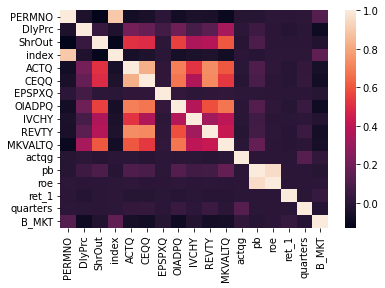

In [31]:
import seaborn as sns
sns.heatmap(cstat.corr())

According to this heatmap, We see that the actqg row is nearly orthogonal to every other variables! Although the ACTQ itself has a lot of correlationship with other number in the financial reports, we do not observe the same effect for the growth in asset. It seems like the growth of asset behaves independently! Another interesting not is return is also almost completely orthogonal to asset growth. Just for fun, we will find the correlation between future and future asset growth.

#### 2.1.2 Further Exploring Correlations

In [32]:
pd.DataFrame(data=[cstat['ret_1'].values,cstat['B_MKT'].shift(-1).values]).T.corr()

,0,1
0,1.000000,0.033873
1,0.033873,1.000000


This is odd. For cross-sectional data, it seems like ex-ante market beta only explains 3 percent of the variations in returns.

In [33]:
pd.DataFrame(data=[cstat['ret_1'].values,cstat['actqg'].values]).T.corr()

,0,1
0,1.000000,-0.006165
1,-0.006165,1.000000


It seems like there is only a little correlation between future asset returns and future returns on the stocks. Is this true for common equity as well?

In [34]:
pd.DataFrame(data=[cstat['ret_1'].values,cstat['CEQQ'].pct_change().shift(-1).values]).T.corr()

,0,1
0,1.000000,-0.000344
1,-0.000344,1.000000


This relationship becomes even smaller (almost non existant) for the growth in common equtiy of the company.

#### 2.1.3 Exploring Asset Growth

In [35]:
cstat['actqg'].describe()

count    101329.000000
mean          0.065838
std           0.444674
min          -1.000000
25%          -0.061638
50%           0.013019
75%           0.091637
max          10.000000
Name: actqg, dtype: float64

From this column, we see the mean growth in asset for each company is around 0.06 quarterly, which exceeds the average risk premium! Of course, this result is highly influenced by the outliers (new, rising companies). The median provides a much more reasonable result: 1.3% quarterly growth, which becomes 5.3% annual growth, higher than the risk-free rate but lower than the market risk premium.

### 2.2 Cross-Sectional Regression

After preprocessing, let's explore how well does our proposed variables explains the cross-sectional returns. Intuitively, since after dropping for nan values, we have some consecutive reports that are more than one quarter apart, we will use these observation to evaluate the long-term predictability of returns.

Intuitively, since shorter time horizon results are a lot more prone to short-term price actions and is highly subjected to noise, we expect to have longer-term regression performing better. Let's explore if that is really the case.

Also, since different industries will behave differently, we expect return predictability to be higher for some industries and lower for others.

#### 2.2.1 Unconditional Regressions

In [36]:
reg1_params = ['ACTQ','CEQQ','EPSPXQ','OIADPQ','IVCHY','REVTY','MKVALTQ','actqg','pb','roe','B_MKT']
target = 'ret_1'
reg1_formula = f"{target}~" + "+".join(reg1_params)
print(smf.ols(reg1_formula,data=cstat).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  ret_1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     12.13
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           3.63e-23
Time:                        20:14:47   Log-Likelihood:            -1.8026e+05
No. Observations:              101329   AIC:                         3.605e+05
Df Residuals:                  101317   BIC:                         3.607e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0361      0.009      4.042      0.0

Although the R^2 is extremely low for this regression, this serves as our sanity check that the rate of growth of assets play a negative role in future returns. This value is significant at alpha = 0.05 and it seems like it's effects are considerably large comparing to the other factors. Now, also observe that the coefficient on market beta is around 6%, which serves as a sanity check that the beta loadings should earn the average stock premium rate.

#### 2.2.2 Regression Conditioned on Industry

To explore the differences and find sectors with potential higher predictability of returns, we condition these regressions on industry via the NAICS code. Note that these codes are preprocessed such that we do not care about the detailed category (dropping the sub-code after the first two digits).

In [37]:
rslt = {}
reg2_params = ['DlyPrc', 'ShrOut', 'ACTQ', 'CEQQ','EPSPXQ', 'OIADPQ', 'IVCHY', 'REVTY', 'MKVALTQ','actqg', 'pb', 'roe', 'quarters', 'B_MKT']
target = 'ret_1'
reg2_formula = f"{target}~" + "+".join(reg1_params)
for code in cstat['NAICS'].unique():
    reg2 = smf.ols(reg1_formula,data=cstat[(cstat['NAICS']==code)]).fit()
    rslt[code] = [reg2.rsquared,reg2.params['actqg'],reg2.tvalues['actqg'],reg2.nobs]
rslt = pd.DataFrame(data=rslt).T
rslt.columns = ['R^2','Coef_actqg','t_actqg','N']
rslt.sort_values('R^2',ascending=False)

,R^2,Coef_actqg,t_actqg,N
99,0.133471,-0.003585,-0.072095,371.0
49,0.131504,-0.385057,-2.068458,162.0
11,0.027699,-0.053589,-1.611313,309.0
61,0.019773,0.071075,1.579794,672.0
23,0.013340,-0.039743,-0.812501,1003.0
45,0.011805,0.038220,0.841614,2124.0
81,0.009601,-0.066363,-0.729788,359.0
44,0.009155,-0.058699,-0.866075,3446.0
31,0.009049,-0.014411,-0.718986,5026.0
72,0.008812,0.053167,1.182324,1922.0


First, note that the indicies are the first two digits of the NAICS code.

From this table, it seems like the returns for stocks belonging to some sectors are easier to forecast comparing to others. Although the number of observations are small for some sectors, we see section code 45 (Retail Trading) is has a considerable 2000+ datapoints with a R^2 of 0.01.

One problem is, however, that the coefficient for our actqg and its corresponding t-statistics is highly variable, going from negative to positive from sector to sector. This might be due to the noise and price action of short term returns, since we are considering only one quarter returns. Next, we will try to do regressions conditioned both on sectors and number of periods. We hope doing regression with longer time span will diminish the effects of short-term price action and substantially decrease noise of our data.

#### 2.2.3 Regression Conditioned on Time-span

In [38]:
rslt = {}
reg2_params = ['DlyPrc', 'ShrOut', 'CURCDQ', 'ACTQ', 'CEQQ','EPSPXQ', 'OIADPQ', 'IVCHY', 'REVTY', 'COSTAT', 'MKVALTQ','actqg', 'pb', 'roe', 'B_MKT']
target = 'ret_1'
reg2_formula = f"{target}~" + "+".join(reg1_params)
for n in range(8):
    reg2 = smf.ols(reg1_formula,data=cstat[(cstat['quarters']==n)]).fit()
    rslt[n] = [reg2.rsquared,reg2.params['actqg'],reg2.tvalues['actqg'],reg2.nobs]
rslt = pd.DataFrame(data=rslt).T
rslt.columns = ['R^2','Coef_actqg','t_actqg','N']
rslt.sort_values('R^2',ascending=False)

,R^2,Coef_actqg,t_actqg,N
7,0.065012,-0.091477,-2.085779,124.0
2,0.009559,-0.056218,-1.817304,5164.0
0,0.002773,-0.026484,-0.524252,1125.0
4,0.002531,0.006360,0.102304,1249.0
6,0.002424,0.008585,0.542342,4467.0
1,0.001614,-0.026496,-1.906850,80761.0
5,0.001469,-0.015919,-0.595465,1835.0
3,0.001071,-0.035980,-1.250323,5958.0


Here, observe that we have the highest R2 for the data with the smallest amount of observations. This is purely due to the fact that we don't have enough observations for 7 quarters ahead of returns. However, We do see predictability increase for observations with more than 1 quarter ahead. Another result of this regression is that we see the coefficients for the growth of assets are negative for nearly all years if we do not condition on sector. Furthermore, balancing the number of observations and R^2 it seems like two years ahead is a sweet spot.

#### 2.2.3 Regression Conditioned on both Industry and Time-span

In [39]:
rslt = {}
reg2_params = ['DlyPrc', 'ShrOut', 'CURCDQ', 'ACTQ', 'CEQQ','EPSPXQ', 'OIADPQ', 'IVCHY', 'REVTY', 'COSTAT', 'MKVALTQ','actqg', 'pb', 'roe', 'quarters', 'B_MKT']
target = 'ret_1'
reg2_formula = f"{target}~" + "+".join(reg1_params)
for quarter in range(7):
    for code in cstat['NAICS'].unique():
        curr_reg = cstat[(cstat['NAICS']==code) & (cstat['quarters']==quarter)]
        if len(curr_reg) < 500:
            continue
        reg2 = smf.ols(reg1_formula,data=curr_reg).fit()
        rslt[quarter,code] = [reg2.rsquared,reg2.params['actqg'],reg2.tvalues['actqg'],reg2.nobs]

rslt = pd.DataFrame(data=rslt).T
rslt.columns = ['R^2','Coef_actqg','t_actqg','N']
rslt.index.names = ['n_quarters','sector']
rslt.sort_values('R^2',ascending=False)

R^2  Coef_actqg   t_actqg        N
n_quarters sector                                         
2          33      0.035442   -0.107790 -1.178579   1477.0
1          61      0.026808    0.092316  1.617087    537.0
2          51      0.025440   -0.119097 -0.968537    593.0
1          45      0.017577   -0.065252 -0.930021   1605.0
           22      0.016834   -0.002220 -0.166750   3247.0
3          51      0.014556   -0.015672 -0.380101    596.0
5          33      0.014021    0.186852  1.860802    539.0
1          23      0.013176   -0.022622 -0.359257    800.0
           31      0.011862    0.008678  0.298322   3930.0
           44      0.011713   -0.043935 -0.517904   2559.0
           72      0.008438    0.076762  1.254576   1541.0
           53      0.007535    0.001944  0.075172   1906.0
           48      0.007048    0.245656  2.173651   3069.0
           56      0.006603   -0.021718 -0.310818   1870.0
           21      0.006438   -0.012208 -0.192701   4821.0
           62      0.006300   -0.088923 -0.724700   1255.0
3          32      0.005724   -0.095430 -1.309645    978.0
1          52      0.005003   -0.014323 -0.529197   1708.0
           42      0.004774   -0.038029 -0.537802   3098.0
2          32      0.003321   -0.030370 -0.655693    766.0
1          54      0.003293    0.129581  1.199392   3125.0
6          33      0.003074    0.024986  0.581600   1334.0
1          32      0.002433   -0.075283 -2.391868  12908.0
3          33      0.002114   -0.046416 -0.526134   1689.0
6          32      0.001783    0.009555  0.298434    774.0
1          51      0.001495   -0.016868 -0.586118   7880.0
           33      0.001451   -0.089224 -2.558647  23468.0

Balancing off the number of observations, it seems like two quarter forward sector 33 has a decent R^2 of 0.035 and with 1477 observations. Not the most exciting results, but definitely something we can work with. In the next section, we will try to perform a strategy on this regression as a comparison to the low asset growth portfolio we have previously discussed.

## 3. Trading Strategy

In this section, we will utilize the previously observed good predictability of manufacturing companies (NAICS Code 33) future returns to design a profitable trading strategy.

### 3.1 Description of the Trading Strategy & Config

In [40]:
split_point = '2015-01-01'
startegy_params = ['DlyPrc', 'ShrOut', 'ACTQ', 'CEQQ','EPSPXQ', 'OIADPQ', 'IVCHY', 'REVTY', 'MKVALTQ','actqg', 'pb', 'roe', 'B_MKT']
sector_code = 33
n_quarters = 2

According to the previous regressions, we decided to trade sector 33 stocks with a holding period of one quarter (The holding period differs from the n_quarters = 2, where the n_quarter measures the frequency of our reports). More specifically, we create a long-short portfolio based on the prediction of our linear regression and assign weights accordingly. Naturally, we will rebalance our portfolio when the reports whenever the quarterly report for a company comes out.

### 3.2 Train Test Split

In [41]:
def winsorize_all(dfs):
    rslt = []
    for df in dfs:
        rslt.append(df.apply(lambda col:winsorize(col)))
    return rslt

In [42]:
mask = (cstat['NAICS'] == sector_code) & (cstat['quarters'] == n_quarters)
# mask = (cstat['quarters'] == n_quarters)

test_set = cstat[(cstat['DATE']>split_point) & mask].copy()
train_set = cstat[(cstat['DATE']<=split_point) & mask]
X_train = train_set[startegy_params]
y_train = train_set['ret_1']
X_test = test_set[startegy_params]
y_test = test_set['ret_1']

# Winsorize the data to remove outliers
X_train,y_train = winsorize_all([X_train,y_train])

print(f"Training Period: {str(train_set['DATE'].min())[:10]} to {str(train_set['DATE'].max())[:10]}")
print(f"Testing Period: {str(test_set['DATE'].min())[:10]} to {str(test_set['DATE'].max())[:10]}")

Training Period: 2001-01-31 to 2014-12-31
Testing Period: 2015-03-31 to 2021-09-30


### 3.3 Strategy Implementations

### 3.3.1 Naive Buy and Hold Portfolio

In [43]:
spy = yf.download("SPY")['Adj Close'].rename('SPY')
spy_ret = spy[test_set['DATE'].unique()].pct_change()
spy_ret[0] = 0
spy_port = (spy_ret + 1).cumprod()

[*********************100%***********************]  1 of 1 completed


Loads the SPY Index

In [44]:
naive_df = test_set[['PERMNO', 'DATE', 'ret_1']].copy()
# naive_df['ret_1'] = naive_df.groupby(['PERMNO'])['DlyPrc'].pct_change().shift(-2)
naive_ret = naive_df.groupby(['DATE'])['ret_1'].mean()
naive_port = (1 + naive_ret).cumprod().rename('Naive Buy and Hold')

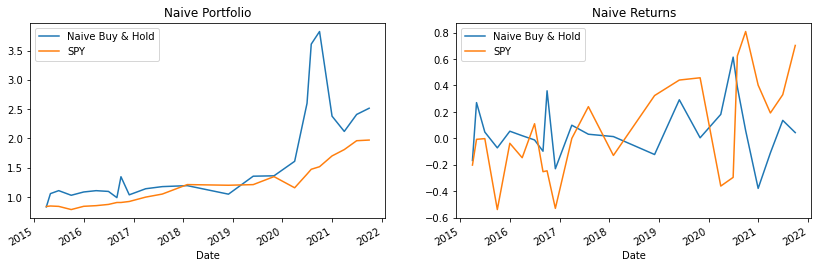

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 7, 4))
naive_port.plot(label='Naive Buy & Hold', ax=axs[0], legend=True)
spy_port.plot(label='SPY', ax=axs[0], legend=True)
naive_ret.plot(label='Naive Buy & Hold', ax=axs[1], legend=True)
spy_ret.plot(label='SPY', ax=axs[1], legend=True)
axs[0].set_title('Naive Portfolio')
axs[1].set_title('Naive Returns')
plt.show()

#### 3.3.2 Proposed Portfolio: Regression on Sector 22, 1 Quarter Holding

In [46]:
target = 'ret_1'
strategy_formula = f"{target}~" + "+".join(startegy_params)
strategy = smf.ols(strategy_formula,data=train_set).fit()
print(strategy.summary())

                            OLS Regression Results                            
Dep. Variable:                  ret_1   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.998
Date:                Sun, 04 Dec 2022   Prob (F-statistic):             0.0184
Time:                        20:14:49   Log-Likelihood:                -1096.5
No. Observations:                 831   AIC:                             2221.
Df Residuals:                     817   BIC:                             2287.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2473      0.073      3.378      0.0

In [47]:
reg_df = test_set[['PERMNO','DATE','ret_1']].copy()
reg_df['ret_1_pred'] = strategy.predict(X_test).values
pred_sum = pd.merge(reg_df,reg_df.groupby('DATE')['ret_1_pred'].apply(lambda x:x.abs().sum()).rename('weight_sum'),on='DATE')['weight_sum'].values
reg_df['strategy_weight'] = reg_df['ret_1_pred'] /pred_sum

In [48]:
reg_df['stock_ret'] = reg_df['strategy_weight'] * reg_df['ret_1']
reg_rf = reg_df.groupby('DATE')['strategy_weight'].agg(lambda x:x.sum()-1) * (0.03/4)
reg_ret = reg_df.groupby('DATE')['stock_ret'].mean() - reg_rf
reg_port = (reg_ret + 1).cumprod()
reg_port = reg_port / reg_port[0]

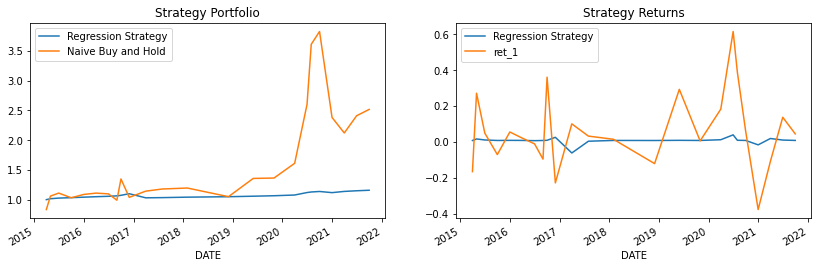

In [49]:
fig,axs = plt.subplots(1,2,figsize=(2*7,4))
reg_port.to_frame().rename({0:'Regression Strategy'},axis=1).join(naive_port).plot(legend=True,ax=axs[0])
reg_ret.to_frame().rename({0:'Regression Strategy'},axis=1).join(naive_ret).plot(legend=True,ax=axs[1])
axs[0].set_title('Strategy Portfolio')
axs[1].set_title('Strategy Returns')
plt.show()

#### 3.3.3 Short-Long Based on Asset Growth

**Note:** The analysis in the section is not rigorous since we do not know the categories (qcuts) of the asset growth before observing the entire time series of asset growth. However, what we did can be a good approximation for the actual portfolio.

In [50]:
mask = (cstat['NAICS'] == sector_code) & (cstat['quarters'] == 2)
# mask = (cstat['quarters'] == n_quarters)

test_set = cstat[(cstat['DATE']>split_point) & mask].copy()
train_set = cstat[(cstat['DATE']<=split_point) & mask]
X_train = train_set[startegy_params]
y_train = train_set['ret_1']
X_test = test_set[startegy_params]
y_test = test_set['ret_1']

# Winsorize the data to remove outliers
X_train,y_train = winsorize_all([X_train,y_train])

print(f"Training Period: {str(train_set['DATE'].min())[:10]} to {str(train_set['DATE'].max())[:10]}")
print(f"Testing Period: {str(test_set['DATE'].min())[:10]} to {str(test_set['DATE'].max())[:10]}")

Training Period: 2001-01-31 to 2014-12-31
Testing Period: 2015-03-31 to 2021-09-30


In [51]:
actqg_df = test_set[['PERMNO','DATE','ret_1','actqg']].copy()
actqg_df['actqgq'] = pd.qcut(test_set['actqg'],5,labels=list(range(1,6))).astype(np.int16)
actqg_df = actqg_df[actqg_df['actqgq'] == 1]
actqg_ret = actqg_df.groupby(['DATE'])['ret_1'].mean()
acqtg_port = (1 + actqg_ret).cumprod().rename()

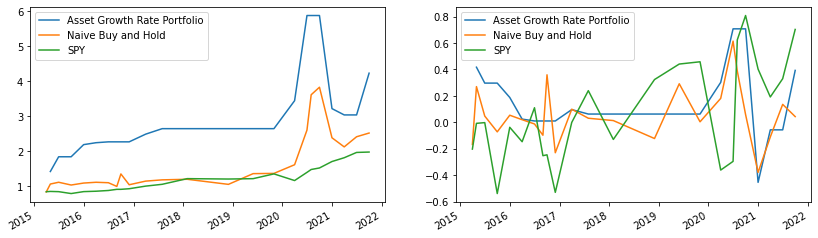

In [52]:
fig,axs = plt.subplots(1,2,figsize=(2*7,4))

port_plot = pd.concat([acqtg_port,naive_port,spy_port],axis=1)
port_plot.columns = ['Asset Growth Rate Portfolio','Naive Buy and Hold','SPY']
port_plot = port_plot.fillna(method='pad')
port_plot.plot(legend=True,ax=axs[0],style='-')

ret_plot = pd.concat([actqg_ret,naive_ret,spy_ret],axis=1)
ret_plot = ret_plot.fillna(method='pad')
ret_plot.columns = ['Asset Growth Rate Portfolio','Naive Buy and Hold','SPY']
ret_plot.plot(legend=True,ax=axs[1])

plt.show()

### 3.4 Analysis of Strategies

In [62]:
def eval_portfolio(port_ret,spy_ret):
    sharpe = (port_ret - 0.03 / 4).mean() / port_ret.std() * np.sqrt(4)
    mean_ret = (port_ret + 1).prod() ** (1/7) - 1
    beta = np.cov(port_ret,spy_ret)[0,1]/port_ret.var()
    print(f"Sharpe Ratio:{round(sharpe,4)}")
    print(f"Mean Return:{round(mean_ret,4)}")
    print(f"Market Beta:{round(beta,4)}\n")

In [63]:
print(f'---Strategy:Regression on Sector:{sector_code}, {n_quarters} quarters holding period---')
eval_portfolio(reg_ret,spy_ret)

print(f'---Strategy:Naive Buy and Hold')
eval_portfolio(naive_ret,spy_ret)

print(f'---Portfolio: SPY---')
eval_portfolio(spy_ret,spy_ret)

print(f'---Portfolio: actgq---')
eval_portfolio(actqg_ret,spy_ret[actqg_ret.index])

---Strategy:Regression on Sector:33, 2 quarters holding period---
Sharpe Ratio:-0.1052
Mean Return:0.0222
Market Beta:-2.2706

---Strategy:Naive Buy and Hold
Sharpe Ratio:0.4862
Mean Return:0.1409
Market Beta:-0.1223

---Portfolio: SPY---
Sharpe Ratio:0.3802
Mean Return:0.0437
Market Beta:1.0

---Portfolio: actgq---
Sharpe Ratio:1.0878
Mean Return:0.2287
Market Beta:-0.3901

